Market-1501 dataset : https://www.kaggle.com/pengcw1/market-1501

!git clone https://github.com/parth1620/Person-Re-Id-Dataset

In [14]:
# -*- coding: utf-8 -*-

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
import torch 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

import sys
import os
import utils
import configparser


# =====================
# GET CONFIG VARIABLES
# =====================

config = configparser.ConfigParser()
config.read('config.ini')

BatchSize = config.getint('TRAIN', 'BatchSize')
Epochs = config.getint('TRAIN', 'Epochs')
LearningRate = config.getfloat('TRAIN', 'LearningRate')
file = config.get('TRAIN', 'TrainFile')
device = config.get('TRAIN', 'Device')

dirname = os.path.dirname("__file__")
DATA_DIR = os.path.join(dirname, "Person-Re-Id-Dataset/train/")
FILE_PATH = os.path.join(dirname, "Person-Re-Id-Dataset/", file)
DEVICE = device
BATCH_SIZE = BatchSize
EPOCHS = Epochs
LR = LearningRate

In [15]:
df = pd.read_csv(FILE_PATH)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [24]:
idx = 11

row = df.iloc[idx]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

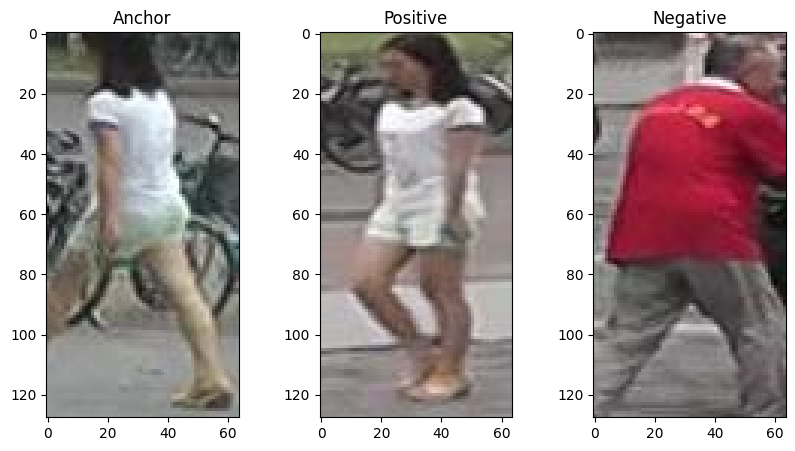

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

### TRAIN AND VAL DATASETS

In [26]:
train_df, valid_df = train_test_split(df,
                                      test_size=0.2,
                                      random_state=42)

### CREATE APN DATASET

In [27]:
class APN_Dataset(Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        
        A_img = io.imread(DATA_DIR + row.Anchor)
        A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0 

        P_img = io.imread(DATA_DIR + row.Positive)
        P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0 
        
        N_img = io.imread(DATA_DIR + row.Negative)
        N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0
        
        return A_img, P_img, N_img   

In [29]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


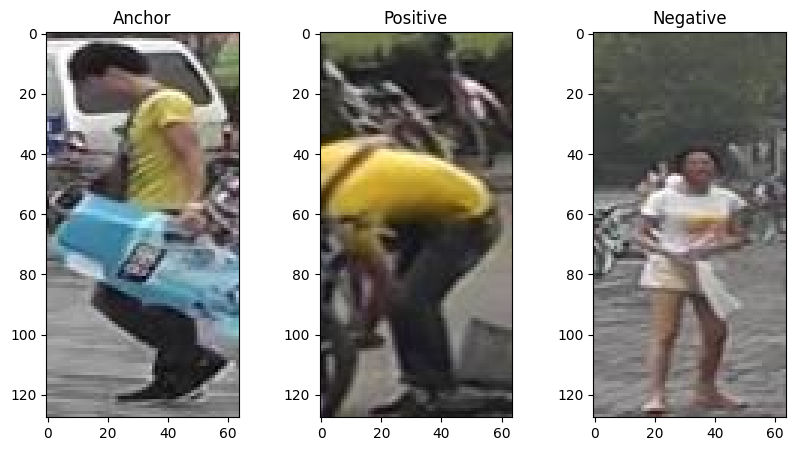

In [30]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

### LOAD INTO BATCHES

In [31]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [32]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [35]:
for A, P, N in trainloader:
    break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


### CREATE MODEL

In [38]:
class APN_Model(nn.Module):
    
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()
        
        self.efficientnet = timm.create_model("efficientnet_b0", pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)
        
    def forward(self, images):
        
        embeddings = self.efficientnet(images)
        
        return embeddings

In [40]:
model = APN_Model()
model.to(DEVICE);

### TRAIN AND EVAL FUNCTION

In [44]:
def train_fn(model, dataloader, optimizer, criterion):
    
    model.train()
    
    total_loss = 0.0
    
    for A, P, N in tqdm(dataloader):
        
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
        
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        
        loss = criterion(A_embs, P_embs, N_embs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)
        
        
def eval_fn(model, dataloader, criterion):
    
    model.eval()
    
    total_loss = 0.0
    
    with torch.no_grad():
        for A, P, N in tqdm(dataloader):

            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()

        return total_loss / len(dataloader)

In [43]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [45]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("SUCCESS SAVING WEIGHTS")
        
    print(f"EPOCHS: {i+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}")

100%|██████████| 25/25 [00:05<00:00,  4.87it/s]


SUCCESS SAVING WEIGHTS
EPOCHS: 1, Train Loss: 0.6093354818224906, Valid Loss: 0.4448857867717743


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


SUCCESS SAVING WEIGHTS
EPOCHS: 2, Train Loss: 0.27364615693688393, Valid Loss: 0.32020846009254456


100%|██████████| 25/25 [00:03<00:00,  7.89it/s]


SUCCESS SAVING WEIGHTS
EPOCHS: 3, Train Loss: 0.14408661425113678, Valid Loss: 0.2667315900325775


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


SUCCESS SAVING WEIGHTS
EPOCHS: 4, Train Loss: 0.08968753144145011, Valid Loss: 0.13061108767986299


100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


EPOCHS: 5, Train Loss: 0.06345281839370727, Valid Loss: 0.14745937764644623


100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


EPOCHS: 6, Train Loss: 0.05661057963967323, Valid Loss: 0.15035272181034087


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


EPOCHS: 7, Train Loss: 0.05004172399640083, Valid Loss: 0.18500591158866883


100%|██████████| 25/25 [00:03<00:00,  6.26it/s]


EPOCHS: 8, Train Loss: 0.06473949328064918, Valid Loss: 0.18540261507034303


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


EPOCHS: 9, Train Loss: 0.08697703801095485, Valid Loss: 0.23586293876171113


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


EPOCHS: 10, Train Loss: 0.080016348361969, Valid Loss: 0.15205417811870575


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


EPOCHS: 11, Train Loss: 0.039490154683589934, Valid Loss: 0.15093008816242218


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


SUCCESS SAVING WEIGHTS
EPOCHS: 12, Train Loss: 0.03298930712044239, Valid Loss: 0.1135199373960495


100%|██████████| 25/25 [00:04<00:00,  6.08it/s]


EPOCHS: 13, Train Loss: 0.01512395367026329, Valid Loss: 0.1316501161456108


100%|██████████| 25/25 [00:03<00:00,  6.46it/s]


EPOCHS: 14, Train Loss: 0.009466563910245895, Valid Loss: 0.11458874583244323


100%|██████████| 25/25 [00:03<00:00,  6.46it/s]

EPOCHS: 15, Train Loss: 0.01841375231742859, Valid Loss: 0.16225143074989318


### GET ANCHOR EMBEDDINGS

In [51]:
def get_encoding_csv(model, A_img_names):
    A_img_names_arr = np.array(A_img_names)
    encodings_list = []
    
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(A_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A.to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # (c, h, w) -> (Batch, c, h, w)
            encodings_list.append(A_enc.squeeze().cpu().detach().numpy())
            
        encodings = np.array(encodings_list)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([A_img_names, encodings], axis=1)
        
    return df_enc

In [50]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [00:38<00:00, 103.63it/s]


In [53]:
df_enc.to_csv("anchor_database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.036781,-0.158449,-0.149390,0.219823,0.181913,-0.798546,0.407404,-0.908220,0.065405,...,0.797954,-0.260875,0.152919,-0.311729,-0.283768,-0.368395,-0.193252,0.110636,-0.480605,-0.235133
1,1420_c3s3_061978_03.jpg,0.509081,0.163766,-0.090624,0.056123,-0.312411,-0.815399,0.302435,-0.458376,0.168527,...,0.476795,-0.545330,0.387001,0.096851,-0.056482,0.107589,-0.115658,-0.052005,-0.191006,-0.160186
2,1420_c5s3_062565_05.jpg,-0.256501,-0.220970,-0.218558,0.357039,0.328890,-0.775397,0.572361,-0.817922,-0.034580,...,0.550942,-0.025001,-0.004466,-0.344226,-0.453254,-0.485779,-0.270605,0.016943,-0.465168,-0.336470
3,1420_c6s3_085592_04.jpg,0.065008,0.020702,-0.177436,0.174495,0.353636,-0.715661,0.324982,-0.983026,0.166730,...,0.800406,-0.415046,0.455277,-0.035524,-0.051312,-0.326993,-0.209005,0.034133,-0.336227,-0.155495
4,0663_c5s3_085987_03.jpg,-0.686495,-0.679835,0.097917,-0.017429,0.836851,0.748539,-0.042451,-0.492840,0.161733,...,-0.016082,-0.091674,-0.335223,-0.859833,0.364451,-0.443348,-0.205939,-0.000160,0.065703,0.276039


### INFERENCE

In [54]:
def euclidean_dist(img_enc, A_enc_arr):
    
    dist = np.sqrt(np.dot((img_enc - A_enc_arr), 
                          (img_enc - A_enc_arr).T))
    
    return dist

In [83]:
# get encodeing of a sample

idx = 4

img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()

with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [84]:
# get distances from the sample encoding to all other anchor encondings

A_enc_arr = df_enc.iloc[:, 1:].to_numpy()
A_img_names = df_enc["Anchor"]

distance = []

for i in range(A_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, A_enc_arr[i:i+1, :])
    distance = np.append(distance, dist)

In [85]:
closest_idx = np.argsort(distance)

closest_idx

array([   4,  814, 1082, ..., 1026, 2378, 1102])

/usr/local/lib/python3.9/site-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


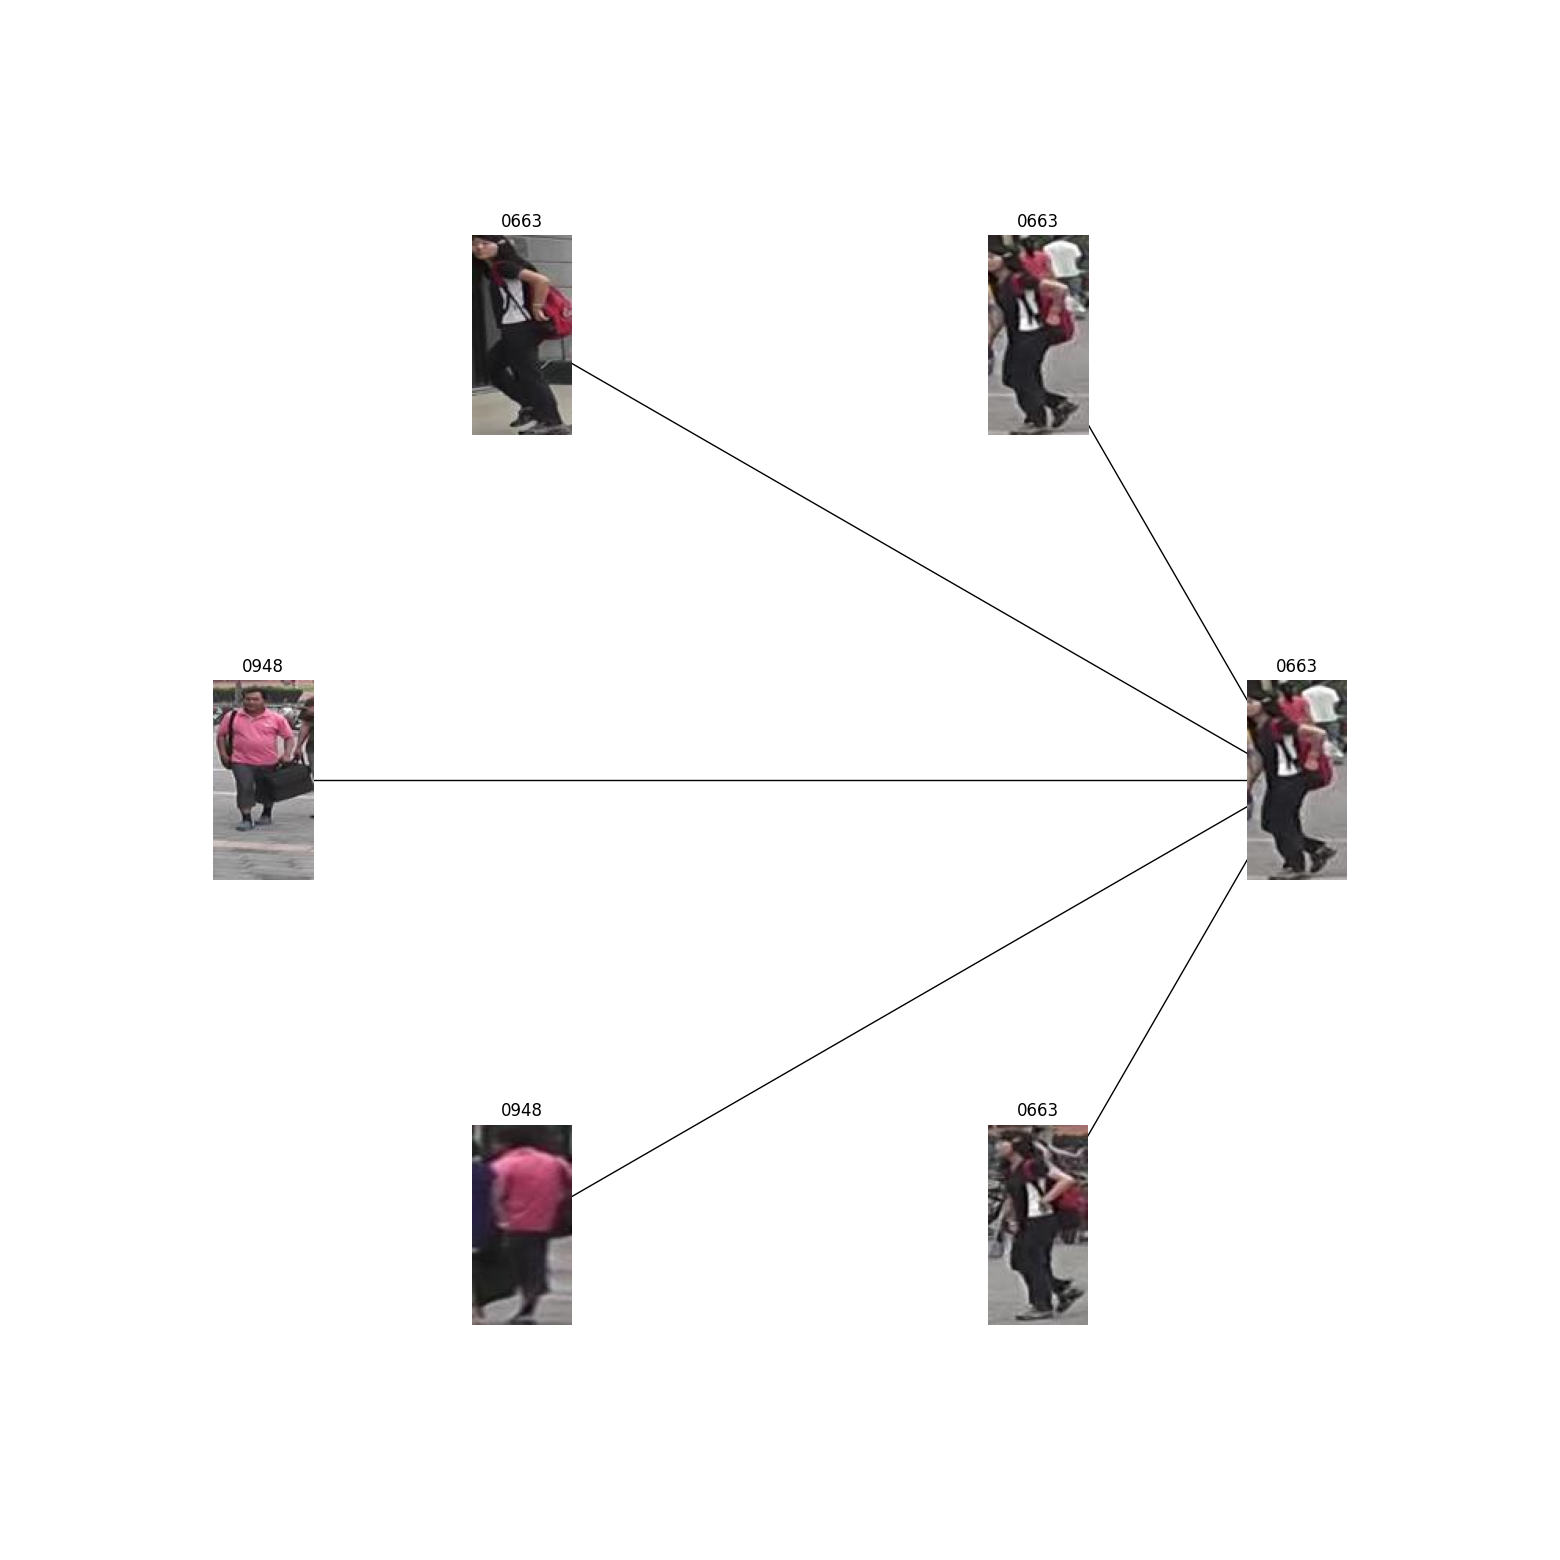

In [87]:
utils.plot_closest_imgs(A_img_names, 
                        DATA_DIR, 
                        img, 
                        img_path, 
                        closest_idx, 
                        distance, 
                        no_of_closest = 5);